In [1]:
import torch
import torch.nn.functional as F
import model, dataset, utils
import transform as trans
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
import numpy as np

import cv2
import torchvision
import torch
import torchvision.transforms as transforms
# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

!pip install torch-lr-finder

In [2]:
device = utils.get_device()
cuda = torch.cuda.is_available()
SEED = 42

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available:  True


In [3]:
## To get the std and mean value

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-10 dataset
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
pixel_means = cifar10_train.data.mean(axis=(0,1,2)) / 255.0
pixel_stds = cifar10_train.data.std(axis=(0,1,2)) / 255.0

print('CIFAR-10 pixel means:', pixel_means)
print('CIFAR-10 pixel stds:', pixel_stds)
print(cifar10_train.data.shape)

100%|██████████| 170498071/170498071 [00:05<00:00, 29234626.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
CIFAR-10 pixel means: [0.49139968 0.48215841 0.44653091]
CIFAR-10 pixel stds: [0.24703223 0.24348513 0.26158784]
(50000, 32, 32, 3)


In [4]:
class args():
    def __init__(self,device = 'cpu' ,use_cuda = False) -> None:
        self.batch_size = 512
        self.device = device
        self.use_cuda = use_cuda
        self.kwargs = {'num_workers': 1, 'pin_memory': True} if self.use_cuda else {}

In [5]:
train_transforms = trans.get_train_transforms(pixel_means, pixel_stds)
test_transforms = trans.get_test_transforms(pixel_means, pixel_stds)

trainset = dataset.Cifar10SearchDataset(root='./data', train=True,
                                download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args().batch_size,
                                          shuffle=True, **args().kwargs)

testset = dataset.Cifar10SearchDataset(root='./data', train=False,
                               download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args().batch_size,
                                         shuffle=True, **args().kwargs)

Files already downloaded and verified
Files already downloaded and verified


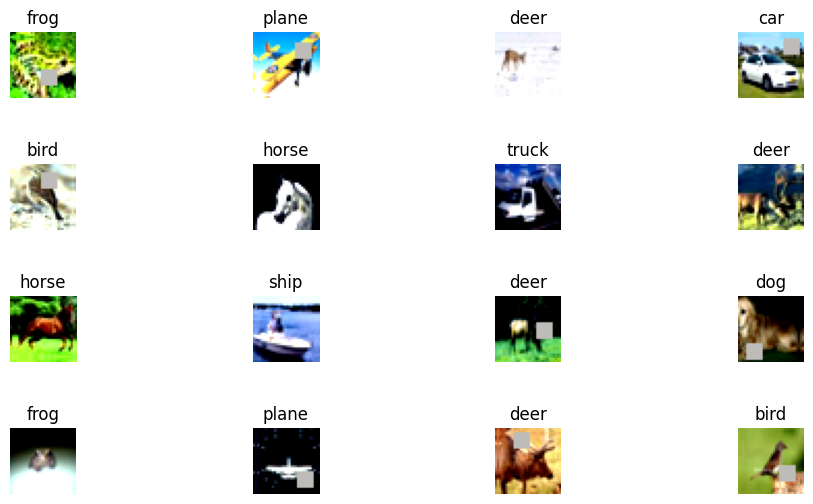

In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

utils.visualise_dataset(train_loader, classes)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
cnnmodel = model.Net().to(device)
summary(cnnmodel, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.93E-02


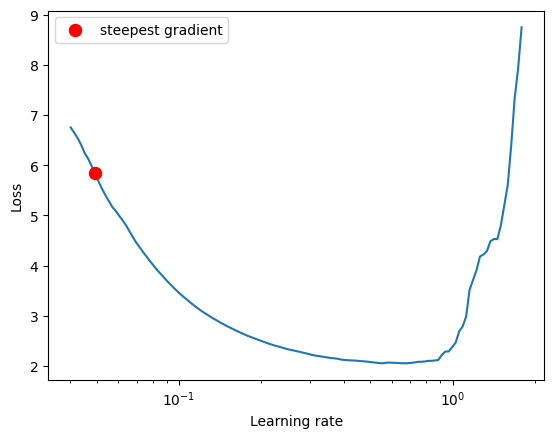

In [9]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnnmodel.parameters(), lr=0.03, weight_decay=1e-5)
lr_finder = LRFinder(cnnmodel, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [10]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24
misclassified = []
actual_labels = []
predicted_labels = []

scheduler = OneCycleLR(
    optimizer=optimizer,
    max_lr=4.93E-02,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=5/EPOCHS,
    div_factor=100,
    final_div_factor=100,
    three_phase=False,
    anneal_strategy="linear"
)

In [11]:
for epoch in range(1, EPOCHS+1):
  print(f'Epoch {epoch}')
  model.train(cnnmodel, device, train_loader, criterion, optimizer, epoch, scheduler)
  model.test(cnnmodel, device, test_loader)

Epoch 1


Loss=0.9739158153533936 Batch_id=97 Accuracy=51.80: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Average loss: 1.4356, Accuracy: 5387/10000 (53.87%)

Epoch 2


Loss=0.8560057282447815 Batch_id=97 Accuracy=67.99: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]



Test set: Average loss: 1.3766, Accuracy: 6325/10000 (63.25%)

Epoch 3


Loss=0.6005896329879761 Batch_id=97 Accuracy=73.31: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]



Test set: Average loss: 0.6842, Accuracy: 7726/10000 (77.26%)

Epoch 4


Loss=0.6220296621322632 Batch_id=97 Accuracy=78.58: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]



Test set: Average loss: 0.5957, Accuracy: 7986/10000 (79.86%)

Epoch 5


Loss=0.7001932859420776 Batch_id=97 Accuracy=81.01: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Average loss: 0.7459, Accuracy: 7450/10000 (74.50%)

Epoch 6


Loss=0.4482543468475342 Batch_id=97 Accuracy=82.77: 100%|██████████| 98/98 [00:28<00:00,  3.40it/s]



Test set: Average loss: 0.8477, Accuracy: 7468/10000 (74.68%)

Epoch 7


Loss=0.4771130084991455 Batch_id=97 Accuracy=83.86: 100%|██████████| 98/98 [00:28<00:00,  3.39it/s]



Test set: Average loss: 0.5743, Accuracy: 8166/10000 (81.66%)

Epoch 8


Loss=0.4080042541027069 Batch_id=97 Accuracy=85.62: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]



Test set: Average loss: 0.5839, Accuracy: 8174/10000 (81.74%)

Epoch 9


Loss=0.3624468445777893 Batch_id=97 Accuracy=86.80: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]



Test set: Average loss: 0.5093, Accuracy: 8273/10000 (82.73%)

Epoch 10


Loss=0.4606637954711914 Batch_id=97 Accuracy=87.50: 100%|██████████| 98/98 [00:28<00:00,  3.41it/s]



Test set: Average loss: 0.4726, Accuracy: 8430/10000 (84.30%)

Epoch 11


Loss=0.31093937158584595 Batch_id=97 Accuracy=88.44: 100%|██████████| 98/98 [00:28<00:00,  3.42it/s]



Test set: Average loss: 0.8022, Accuracy: 7682/10000 (76.82%)

Epoch 12


Loss=0.3161720931529999 Batch_id=97 Accuracy=89.05: 100%|██████████| 98/98 [00:28<00:00,  3.42it/s]



Test set: Average loss: 0.4186, Accuracy: 8666/10000 (86.66%)

Epoch 13


Loss=0.269056111574173 Batch_id=97 Accuracy=89.59: 100%|██████████| 98/98 [00:28<00:00,  3.39it/s]



Test set: Average loss: 0.3784, Accuracy: 8731/10000 (87.31%)

Epoch 14


Loss=0.23078879714012146 Batch_id=97 Accuracy=89.66: 100%|██████████| 98/98 [00:28<00:00,  3.42it/s]



Test set: Average loss: 0.4131, Accuracy: 8616/10000 (86.16%)

Epoch 15


Loss=0.19499747455120087 Batch_id=97 Accuracy=90.98: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]



Test set: Average loss: 0.3738, Accuracy: 8769/10000 (87.69%)

Epoch 16


Loss=0.37838834524154663 Batch_id=97 Accuracy=91.37: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]



Test set: Average loss: 0.3533, Accuracy: 8861/10000 (88.61%)

Epoch 17


Loss=0.18428896367549896 Batch_id=97 Accuracy=91.69: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Average loss: 0.3461, Accuracy: 8873/10000 (88.73%)

Epoch 18


Loss=0.17717817425727844 Batch_id=97 Accuracy=93.00: 100%|██████████| 98/98 [00:28<00:00,  3.41it/s]



Test set: Average loss: 0.3166, Accuracy: 8974/10000 (89.74%)

Epoch 19


Loss=0.21200327575206757 Batch_id=97 Accuracy=93.54: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Average loss: 0.3559, Accuracy: 8902/10000 (89.02%)

Epoch 20


Loss=0.09564343094825745 Batch_id=97 Accuracy=94.23: 100%|██████████| 98/98 [00:28<00:00,  3.41it/s]



Test set: Average loss: 0.3210, Accuracy: 8990/10000 (89.90%)

Epoch 21


Loss=0.1579410284757614 Batch_id=97 Accuracy=95.37: 100%|██████████| 98/98 [00:28<00:00,  3.39it/s]



Test set: Average loss: 0.2755, Accuracy: 9145/10000 (91.45%)

Epoch 22


Loss=0.09104599058628082 Batch_id=97 Accuracy=96.31: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Average loss: 0.2627, Accuracy: 9182/10000 (91.82%)

Epoch 23


Loss=0.07745090872049332 Batch_id=97 Accuracy=97.32: 100%|██████████| 98/98 [00:28<00:00,  3.41it/s]



Test set: Average loss: 0.2460, Accuracy: 9250/10000 (92.50%)

Epoch 24


Loss=0.05214499309659004 Batch_id=97 Accuracy=98.01: 100%|██████████| 98/98 [00:28<00:00,  3.41it/s]



Test set: Average loss: 0.2405, Accuracy: 9272/10000 (92.72%)



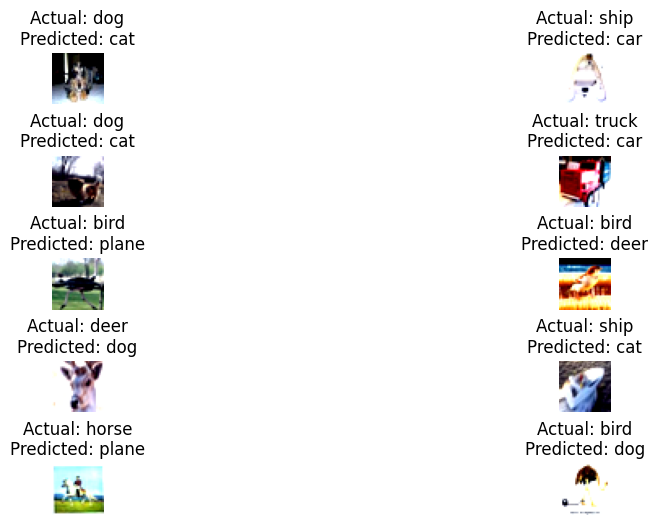

In [12]:
# To show the misclassified Images
model.plot_misclassifeid_images()

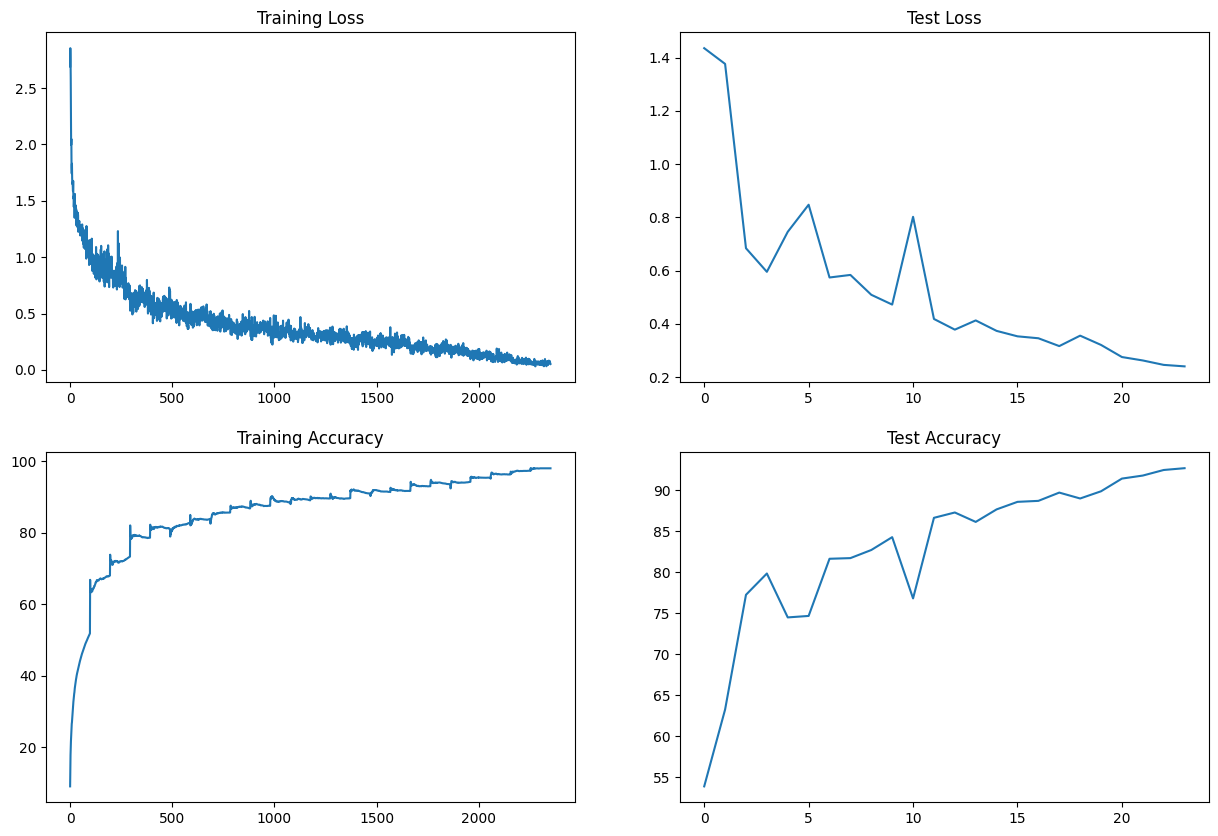

In [13]:
# Graph
model.plot_loss_accuracy_graph()